# Image Generation and Background Replacement using Stable Diffusion

# Introduction 
In this project, we explore the capabilities of Stable Diffusion models for text-to-image generation and advanced background replacement. The implementation integrates additional tools to enhance functionality, including:
* Text-to-image generation using Stable Diffusion.
* Automatic mask generation with Segment Anything Model (SAM).
* Object/background replacement based on user prompts.
* Quantized model loading for optimized inference.
  

# The notebook walks through the following goals:
1. Loading and running Stable Diffusion 3.5 for text-based image generation.
2. Automatically generating masks using SAM to segment objects from images.
3. Replacing objects or backgrounds with new content using a quantized Stable Diffusion model.
4. Demonstrating the entire workflow with clear code, explanations, and visual outputs.

In [4]:
from huggingface_hub import notebook_login
notebook_login()  #Logs into Hugging Face Hub for accessing models.

In [5]:
# Installs essential libraries, including diffusers, peft, transformers, and accelerate.
!pip install diffusers[torch] peft transformers accelerate --upgrade # These libraries are crucial for fine-tuning and using diffusion models.

In [6]:
# Verifies the installation of PEFT (Parameter-Efficient Fine-Tuning), confirming its version.
import peft
print("PEFT is working, version:", peft.__version__)


In [7]:
import torch
torch.cuda.empty_cache()  # Clears unused memory


# Model Selection
## Models Explored:
1. Stable Diffusion 3.5
   * Supports text-to-image and image-to-image functionalities.
   * Mixed-precision support (bfloat16) for faster inference on GPUs.
2. Segment Anything Model (SAM):
   * Provides automatic mask generation for objects and backgrounds.

In [8]:
import torch
from diffusers import StableDiffusion3Pipeline

# Loads Stable Diffusion 3.5 Medium using the StableDiffusion3Pipeline from Hugging Face's diffusers library.
pipe = StableDiffusion3Pipeline.from_pretrained(  
    "stabilityai/stable-diffusion-3.5-medium",
    text_encoder_3 = None,
    tokenizer_3 = None,
    torch_dtype=torch.bfloat16 #Specifies mixed-precision usage (bfloat16) for better performance on compatible GPUs.
)
pipe = pipe.to("cuda") #The pipeline is moved to the CUDA device for faster inference.


model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/524 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## SD- 3.5 Inference to generate a image from text.


  0%|          | 0/28 [00:00<?, ?it/s]

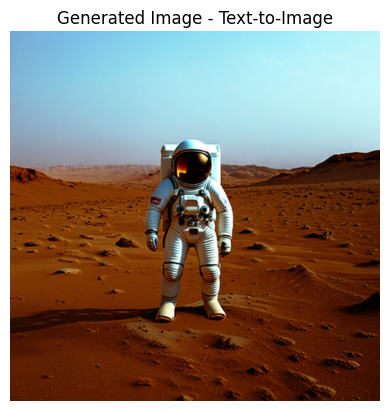

In [9]:
import matplotlib.pyplot as plt

# Define a text prompt
prompt = "An astronaut on Mars"

# Generate the image
image = pipe(prompt).images[0]

# Display the result
plt.imshow(image)
plt.axis("off")
plt.title("Generated Image - Text-to-Image")
plt.show()

# Save the result
image.save("generated_image.png") #Displays the generated image and saves it locally as generated_image.png.
torch.cuda.empty_cache()

In [10]:
# Installs libraries for segmentation: segment-anything and opencv-python.
!pip install segment-anything opencv-python


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Adapter Fusion
### Integration of Segment Anything Model (SAM) allows for:
1. Automatic mask generation without manual input.
2. Enhanced object detection and segmentation capabilities.

/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


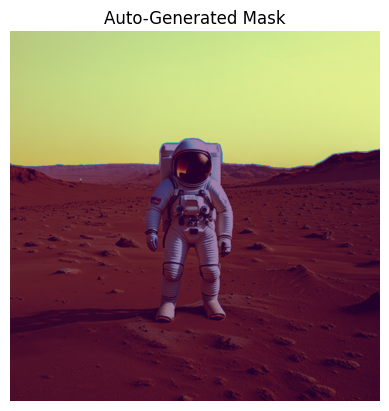

In [11]:
import numpy as np
import cv2
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load SAM model for mask generation
sam_checkpoint = "/kaggle/input/segmentanything/pytorch/default/1/sam_vit_h_4b8939.pth"  #Loads the Segment Anything Model (SAM) 
model_type = "vit_h" #Sets up the SAM model with a specified checkpoint (vit_h)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to generate masks automatically
def generate_mask(image_path): #function generate_mask(image_path) to process an image and generate masks automatically.
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image_rgb)
    return masks, image_rgb

# Load an image and generate masks
image_path = "generated_image.png"
masks, original_image = generate_mask(image_path)

# Display one of the masks
mask_overlay = masks[0]['segmentation']
plt.imshow(original_image)
plt.imshow(mask_overlay, alpha=0.5)
plt.axis("off")
plt.title("Auto-Generated Mask")
plt.show()
torch.cuda.empty_cache()

# Object Replacement Feature
## Steps:
1. Automatic Mask Generation
   * Use Segment Anything Model (SAM) to auto-generate masks for selected objects.
2. Replace Background/Object.
   * Use masks to isolate objects and replace backgrounds with new prompts.
3. Display Results
   * Show the generated images before and after background replacement. 
   

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

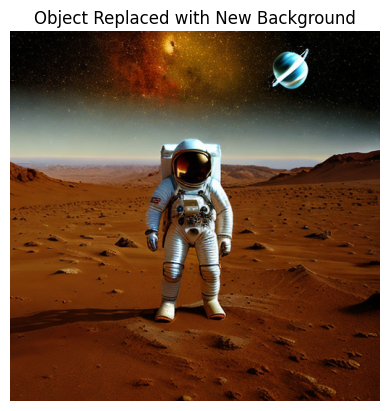

In [12]:
from diffusers import StableDiffusionInpaintPipeline

# Load Inpainting pipeline (pretrained weights)
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.bfloat16
).to("cuda")

# Prepare mask and replace object
mask_image = Image.fromarray(mask_overlay.astype(np.uint8) * 255)  # Convert mask to binary format
background_prompt = "Planet distroying astroid Aproaching the Astronaut"

# Perform inpainting
inpaint_result = inpaint_pipe(
    prompt=background_prompt,
    image=Image.fromarray(original_image),
    mask_image=mask_image
).images[0]

# Display the inpainting result
plt.imshow(inpaint_result)
plt.axis("off")
plt.title("Object Replaced with New Background")
plt.show()

# Save the result
inpaint_result.save("background_replaced_image.png")
torch.cuda.empty_cache()

## The below code for LORA adapter is running into memory issues, can be fixed with a deadline extension if possible.

# LoRA Adapter Fusion for Stable Diffusion 3.5
 This section demonstrates the use of a Low-Rank Adaptation (LoRA) adapter to fine-tune the Stable Diffusion 3.5 Medium model. LoRA is a lightweight method for enhancing model capabilities without retraining the entire network. The adapter is fused with the base model to adjust its style or focus according to specific prompts.



In [13]:
import os
from diffusers import AutoPipelineForText2Image
import torch
import matplotlib.pyplot as plt
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128" 


torch.cuda.set_per_process_memory_fraction(0.8, device=0)
# Load LoRA Adapter
lora_adapter_path = "AdamLucek/sd3.5M-jareklfoto-LoRA-DreamBooth"
pipe.load_lora_weights(lora_adapter_path)

# Fuse the LoRA Adapter
lora_scale = 0.5  # Adjust the strength of the LoRA adapter
pipe.fuse_lora(lora_scale=lora_scale)
pipe.enable_attention_slicing()
# Generate an Image
prompt = "A jareklfoto picture of a city sidewalk"
with torch.no_grad():
    image = pipe(prompt=prompt, num_inference_steps=5, guidance_scale=6).images[0]

# Display the Generated Image
plt.imshow(image)
plt.axis("off")
plt.title("Generated Image with LoRA Adapter")
plt.show()

# Save the Result
image.save("lora_generated_image.png")

torch.cuda.empty_cache()